# HNCDI Explain:  Grover Tutorial 2

This is tutorial 3 on Grover's Algorithm. This is a 3-qubit example, with 1-Grover iteration. 

__Task__. Run through the provided notebook, which steps through the stages of Grover's algorithm. Notice that the good item $x_m=111$ still occurs with high probability, but the other strings now have non-zero probability.

In [1]:
# Import standard Qiskit libraries
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, IBMQ
from qiskit.compiler import transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

from qiskit import execute
from qiskit.providers.ibmq import least_busy

As in tutorial 1, we will now step through Grover's algorithm but for 3-qubits. 

__Step 1__: Create the superposition state $|s \rangle$.

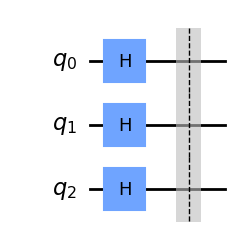

In [2]:
# Define no. of qubits to be n = 3 and create a quantum circuit called "circ" with an n-qubit register.
n = 3
circ = QuantumCircuit(n)

#Apply a Hadamard gate to each qubit in the circuit.
for i in range(n):
    circ.h(i)
    
circ.barrier()
circ.draw('mpl') 

__Step 2__. Here we create the circuit that implements the oracle that marks the good item $111$. The circuit that implements this is the $CCZ$ gate. 

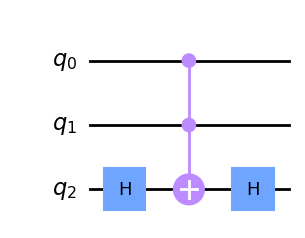

In [3]:
qc = QuantumCircuit(3)

## mark item 111
qc.h([2])
qc.ccx(0,1,2)
qc.h([2])
qc.draw('mpl')

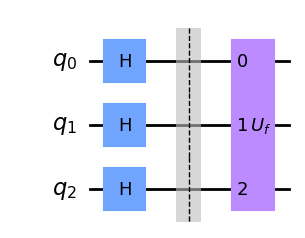

In [4]:
oracle = qc.to_gate()
oracle.name = "$U_f$"
circ.append(oracle, [0,1,2])
circ.draw('mpl') 

__Step 3__. Apply the Grover Diffusion operator.

In [5]:
# This is code provides a general implementation of Grover's Diffusion operator, based on https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm.
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_D$"
    return U_s

{'This is the final Grover Circuit with 1-iteration.'}


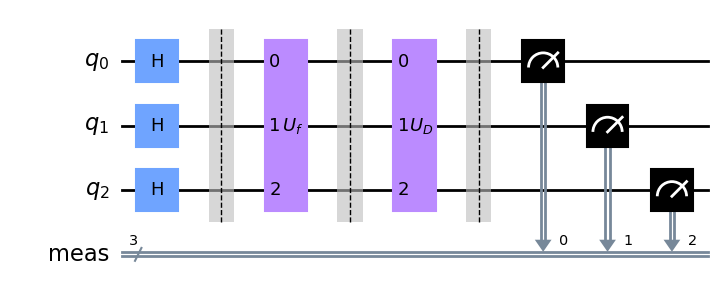

In [6]:
circ.barrier()
circ.append(diffuser(n), [0,1,2])
circ.draw()
circ.measure_all()
print({'This is the final Grover Circuit with 1-iteration.'})
circ.draw('mpl') 

__Step 4__: We will now submit the quantum circuit to A) a simulator and B) a real quantum computer. 

Notice that the marked item $x_m = 111$ was identified with high probability with only one Grover-iteration, however unlike tutorial 1 the other strings now have non-zero probability.

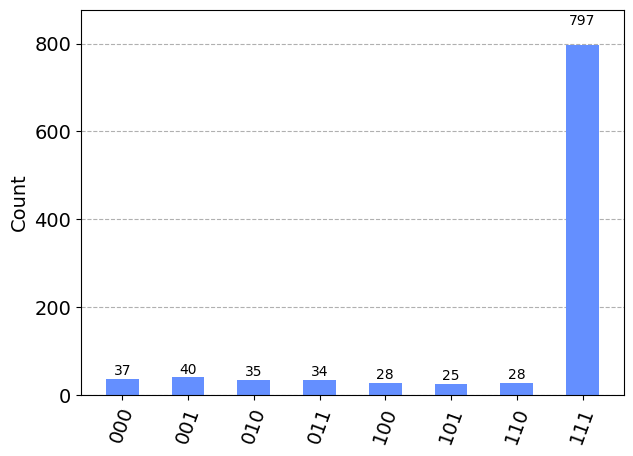

In [7]:
# OPTION 1: RUN ON QUANTUM SIMULATOR
backend = Aer.get_backend('qasm_simulator')
results = execute(circ, backend=backend, shots=1024).result()
answer = results.get_counts()
plot_histogram(answer)

In [ ]:
# OPTION 2: RUN ON QUANTUM HARDWARE


provider = IBMQ.load_account() 
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and not x.configuration().simulator and x.status().operational==True))

#transpile
t_circuit = transpile(circ, device, optimization_level=3)
job = execute(t_circuit, backend = device, shots =1024, optimization_level = 3)
from qiskit.tools.monitor import job_monitor
job_monitor(job, interval = 2)
results = job.result()
answer = results.get_counts(t_circuit)
plot_histogram(answer)

ibmqfactory.load_account:WARNING:2023-06-26 20:26:28,588: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job is queued (None)